In [1]:
import joblib
import os
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from neuroginius.plotting import plot_matrix
from neuroginius.atlas import Atlas

from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from nilearn.maskers import NiftiLabelsMasker
from nilearn import plotting
import nibabel as nib

from bold_dementia.utils.configuration import get_config
from bold_dementia.cogpred import MatrixMasker, make_training_data, plot_haufe_pattern
from bold_dementia.utils.naming import make_run_path

config = get_config()
conn_dir = config["connectivity_matrices"]

ATLAS = "schaefer200"

atlas = Atlas.from_name(ATLAS, soft=False)

k = 3
# Whole brain study
REFNET = np.unique(atlas.macro_labels)
INTER = REFNET
SUFFIX = "prediction" # suffix given to the matrix dir
#REFNET = ("Default",)
#INTER = ("Default",)

sns.reset_defaults()

## Prediction

In [2]:
matrices, metadata = make_training_data(conn_dir, ATLAS, k, test_centre=None, suffix=SUFFIX)
run_path = make_run_path(
    config["output_dir"],
    k=k,
    feat="fc",
    atlas=ATLAS,
    net="".join(REFNET),
    inter="".join(INTER)
)

if len(run_path.name) > 55:
    print("too long")
    run_path = make_run_path(
        config["output_dir"],
        k=k,
        feat="fc",
        atlas=ATLAS,
        net="all",
    )
    
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 12 subjects because of lacking MMMSE
too long


## Model from confounds

In [3]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing as prep
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.metrics import f1_score, make_scorer

ct = make_column_transformer(
    (prep.PolynomialFeatures(), ["current_scan_age"]),
    (prep.OneHotEncoder(), ["SEX", "MCI"]),
    remainder="drop"
)
pipe = make_pipeline(
    ct,
    prep.StandardScaler(),
    LogisticRegression(),
)

outer_cv = GroupKFold(n_splits=8)

confound_scores = cross_val_score(
    pipe,
    metadata,
    metadata.cluster_label.values.astype(int),
    cv=outer_cv,
    groups=metadata.CEN_ANOM.values,
    scoring=make_scorer(f1_score, average="macro")
)
confound_scores

array([0.35645096, 0.27615063, 0.28215768, 0.30211991, 0.28494624,
       0.29745855, 0.25663717, 0.29100529])

## Model from FC

In [4]:
from bold_dementia.cogpred import run_cv
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from nilearn.connectome import vec_to_sym_matrix
from bold_dementia.cogpred import compute_mat_size

net = SGDClassifier(
        loss="log_loss",
        penalty="l1",
        max_iter=3000,
        random_state=2024,
    )

clf = Pipeline(
    [
    ("matrixmasker", MatrixMasker(REFNET, INTER, atlas=atlas)),
    ("scaler", preprocessing.StandardScaler()),
    ("classifier", net)
    ],
    verbose=False
)


cats = ("stable", "slow decline", "steep decline")

test_scores, cm, patterns = run_cv(clf, matrices, metadata, outer_cv)

masker = clf.named_steps["matrixmasker"]
l = len(masker.vec_idx_)
n_regions = compute_mat_size(l)
hmat = vec_to_sym_matrix(
    patterns.transpose((0, 2, 1)), diagonal=np.zeros((outer_cv.n_splits, k, n_regions))
)

              precision    recall  f1-score   support

           0       0.93      0.57      0.71       221
           1       0.06      0.36      0.11        14
           2       0.00      0.00      0.00         3

    accuracy                           0.55       238
   macro avg       0.33      0.31      0.27       238
weighted avg       0.86      0.55      0.66       238

              precision    recall  f1-score   support

           0       0.87      0.46      0.60       101
           1       0.18      0.57      0.28        23
           2       0.12      0.12      0.12        16

    accuracy                           0.44       140
   macro avg       0.39      0.38      0.33       140
weighted avg       0.67      0.44      0.49       140

              precision    recall  f1-score   support

           0       0.88      0.57      0.69       103
           1       0.30      0.56      0.39        25
           2       0.19      0.45      0.27        11

    accuracy        

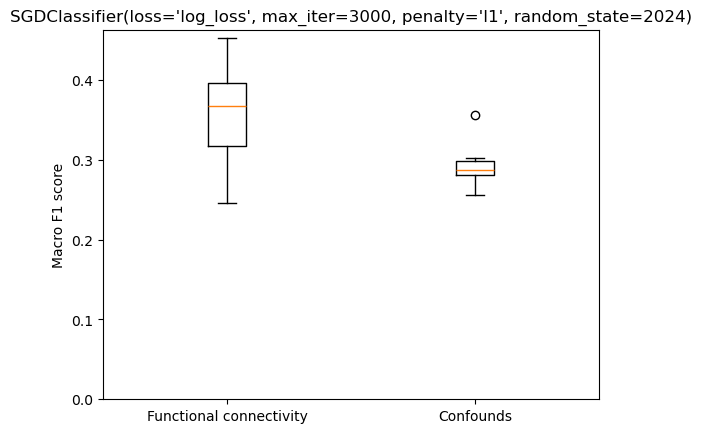

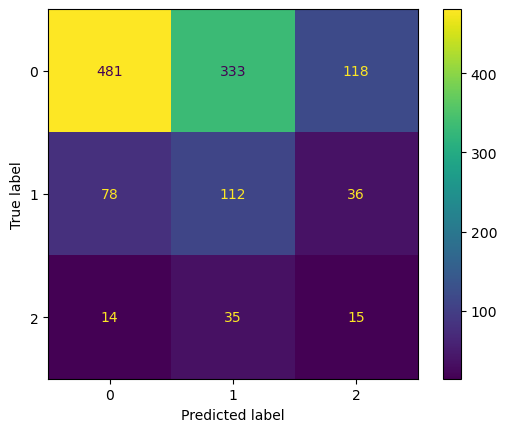

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.boxplot([test_scores, confound_scores])
plt.ylim(0)
plt.title(clf.named_steps["classifier"])
plt.ylabel("Macro F1 score")
plt.xticks(range(1, 3), ["Functional connectivity", "Confounds"])
plt.show()

disp = ConfusionMatrixDisplay(cm.astype(int))
disp.plot()
plt.show()

In [6]:
pd.DataFrame(test_scores).to_csv("output/pred_scores.csv")

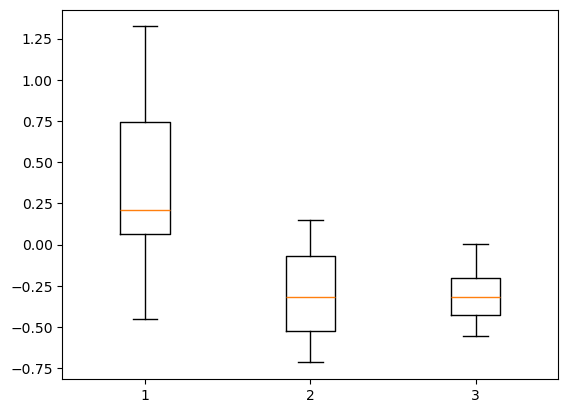

In [7]:
r_stable = hmat[:, 0, ...].mean(axis=(1, 2))
r_slow = hmat[:, 1, ...].mean(axis=(1, 2))
r_steep = hmat[:, 2, ...].mean(axis=(1, 2))
plt.boxplot(
    (
        r_stable,
        r_slow,
        r_steep,
    )
)
plt.show()

In [8]:
atlas = Atlas.from_name(ATLAS)
def net_select(label):
    if label in masker.refnet or label in masker.interaction:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network in masker.refnet or network in masker.interaction:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

class MockAtlas:
    def __init__(self) -> None:
        self.macro_labels = list(map(self.region_split, regions))

    @staticmethod
    def region_split(label):
        return label.split("_")[-2]
        
if np.all(REFNET == np.unique(atlas.macro_labels)):
    disp_atlas = atlas
else:
    disp_atlas = MockAtlas()


# Test significant score

/tmp/ipykernel_3432812/711523915.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(disp_sample, labels=labels)


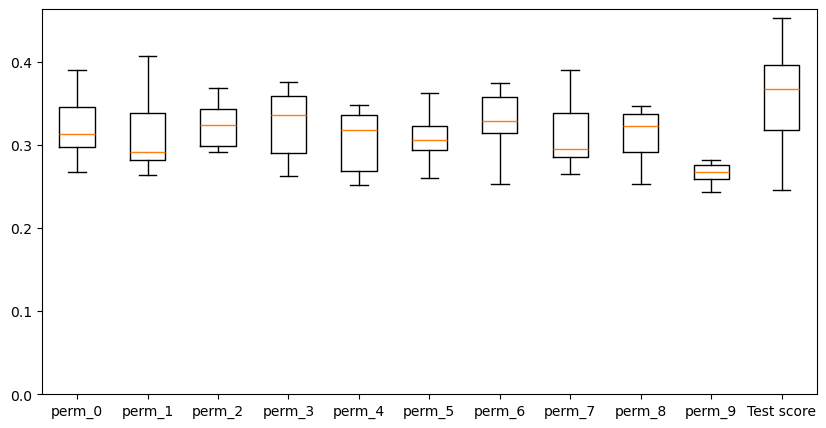

In [9]:
import random

N = 5000
#p = Path("/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-schaefer200_net-Default_inter-Default")
p = run_path
perm_res = joblib.load(p / f"{N}_permutations_res.joblib")
permscores = [pr[0] for pr in perm_res]
permweights = [pr[1] for pr in perm_res]

disp_sample = random.sample(permscores, k=10)
disp_sample.append(test_scores)

labels = [f"perm_{i}" for i in range(10)]
labels.append("Test score")

plt.subplots(figsize=(10, 5))
plt.boxplot(disp_sample, labels=labels)
plt.ylim(0)
plt.show()

median_scores = tuple(map(np.median, permscores))
median_test = np.median(test_scores)
pvalue = (np.sum(median_test < median_scores)+ 1) / (N + 1)

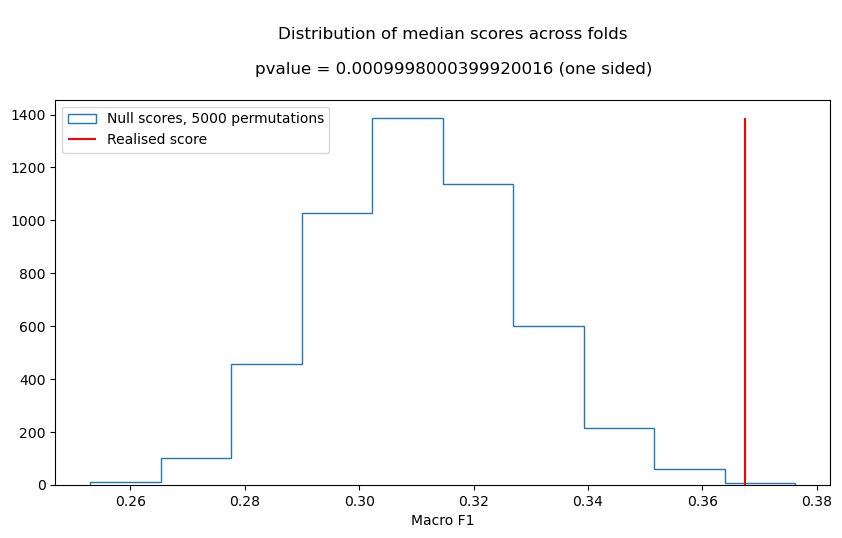

In [10]:
f, ax = plt.subplots(figsize=(10, 5))
h = ax.hist(median_scores, histtype="step", label=f"Null scores, {N} permutations")
ax.vlines(median_test, ymin=0, ymax=np.max(h[0]), color="red", label="Realised score")
ax.set_title(
    f"""
    Distribution of median scores across folds\n
    pvalue = {pvalue} (one sided)
    """
)
ax.legend(loc="upper left")
ax.set_xlabel("Macro F1")
plt.show()

# Multiple comparisons adjustement

## Perms + FDR control

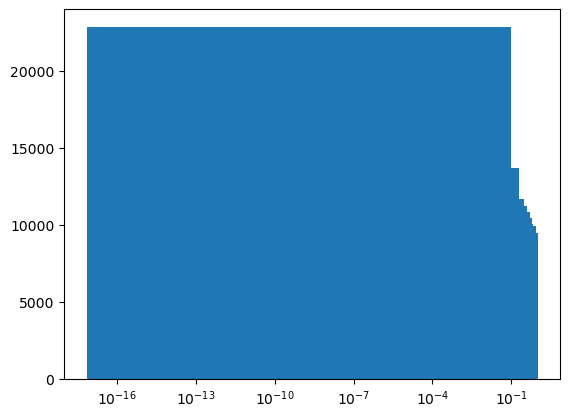

In [11]:
from nilearn.connectome import vec_to_sym_matrix
from statsmodels.stats.multitest import fdrcorrection
n_regions = int(np.sqrt(masker.topology_.sum()))

mean_perm_patterns = np.stack(permweights, axis=0).mean(axis=1)
mean_patterns = np.mean(patterns, axis=0)

pvalues_more = (np.sum(mean_patterns > mean_perm_patterns, axis=0) + 1) / (N + 1)
pvalues_less = (np.sum(mean_patterns < mean_perm_patterns, axis=0) + 1) / (N + 1)
pvalues = np.minimum(pvalues_less, pvalues_more) * 2

pvalues_corr = []
for class_idx in range(k):
    pvalues_corr.append(fdrcorrection(
        pvalues[:, class_idx]
    )[1])
pvalues_corr = np.stack(pvalues_corr, axis=1)
pvalues_corr = vec_to_sym_matrix(
        pvalues.transpose((1, 0)), diagonal=np.zeros((k, n_regions))
)
plt.hist(pvalues_corr.flatten())
plt.xscale("log")
plt.show()

In [21]:
# Map thresholded model weights from tangent to correlation space.
# A scaling factor is applied to avoid numerical errors,
# since projection implies matrix exponential which
# can output very high values.
conn_measure = joblib.load(f"{conn_dir}/atlas-{atlas.name}_{SUFFIX}/connectivity_measure.joblib")
thresh_map_tangent = np.where(pvalues_corr < (0.05), hmat, 0).mean(axis=0)
thresh_map = conn_measure.inverse_transform(thresh_map_tangent / 1e4)

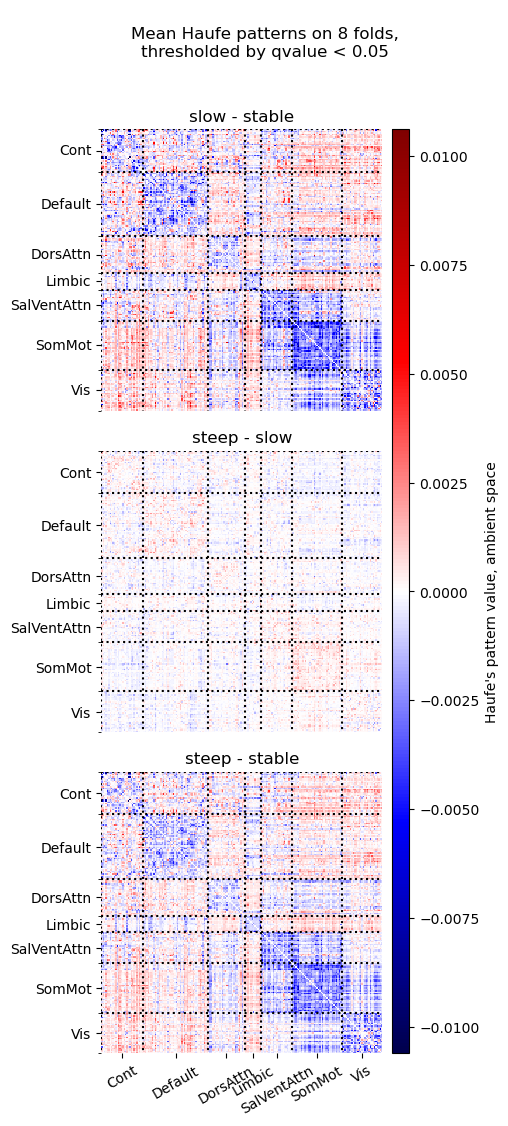

In [22]:
diffmaps = np.zeros((k, *matrices.shape[1:]))
stable_patterns = thresh_map[0, ...]
slow_patterns = thresh_map[1, ...]
steep_patterns = thresh_map[2, ...]

diffmaps[0, ...] = slow_patterns - stable_patterns
diffmaps[1, ...] = steep_patterns - slow_patterns
diffmaps[2, ...] = steep_patterns - stable_patterns

fig = plot_haufe_pattern(diffmaps, disp_atlas, ("slow - stable", "steep - slow", "steep - stable"))
fig.suptitle(
        f"""
        Mean Haufe patterns on {len(hmat)} folds,
        thresholded by qvalue < 0.05
        """)
plt.show()


In [16]:
joblib.dump(thresh_map_tangent[2], "output/haufe_steep.joblib")
joblib.dump(thresh_map_tangent[1], "output/haufe_slow.joblib")
joblib.dump(thresh_map_tangent[0], "output/haufe_stable.joblib")

['output/haufe_stable.joblib']

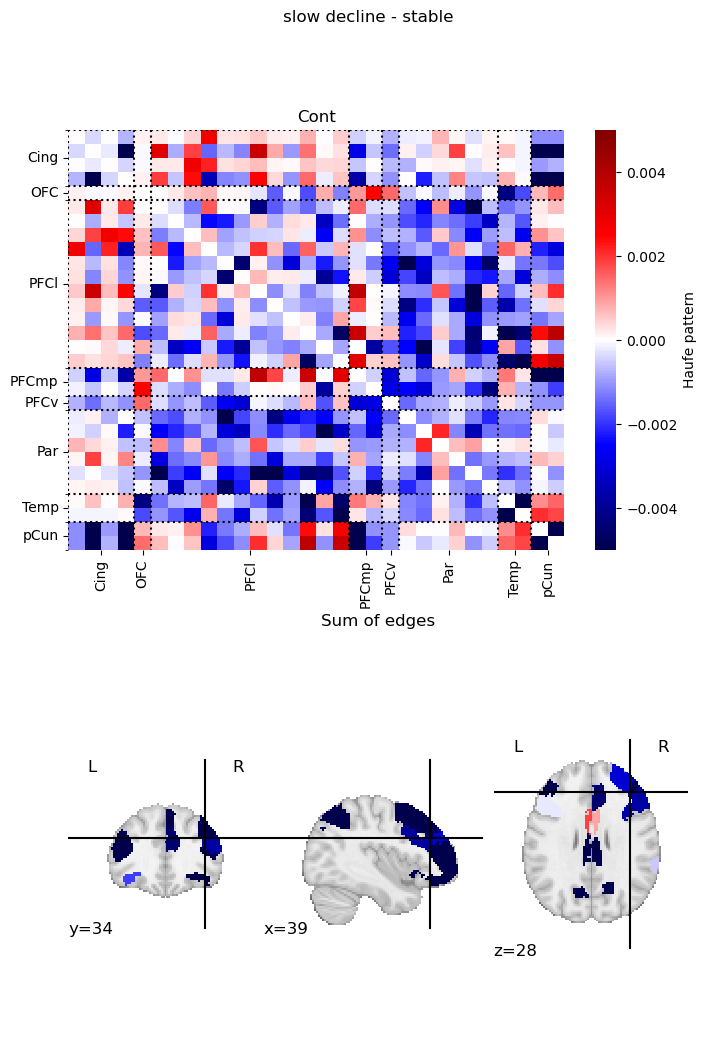

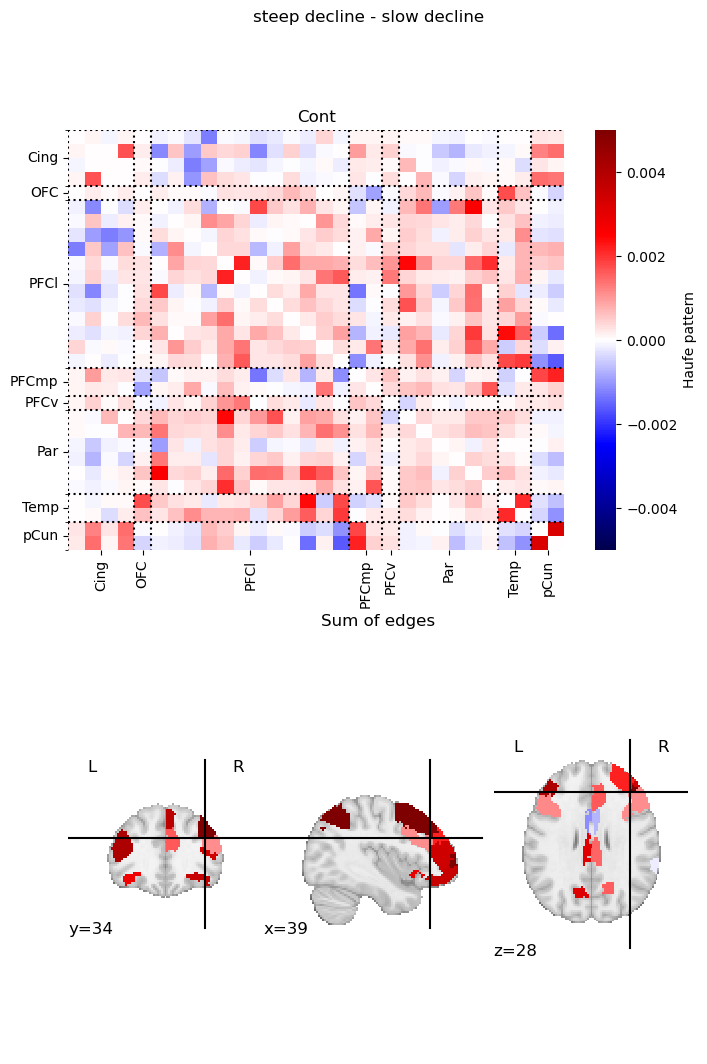

/tmp/ipykernel_3112271/3935268721.py:61: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  with PdfPages("output/zooms_.pdf") as pages:


IndexError: tuple index out of range

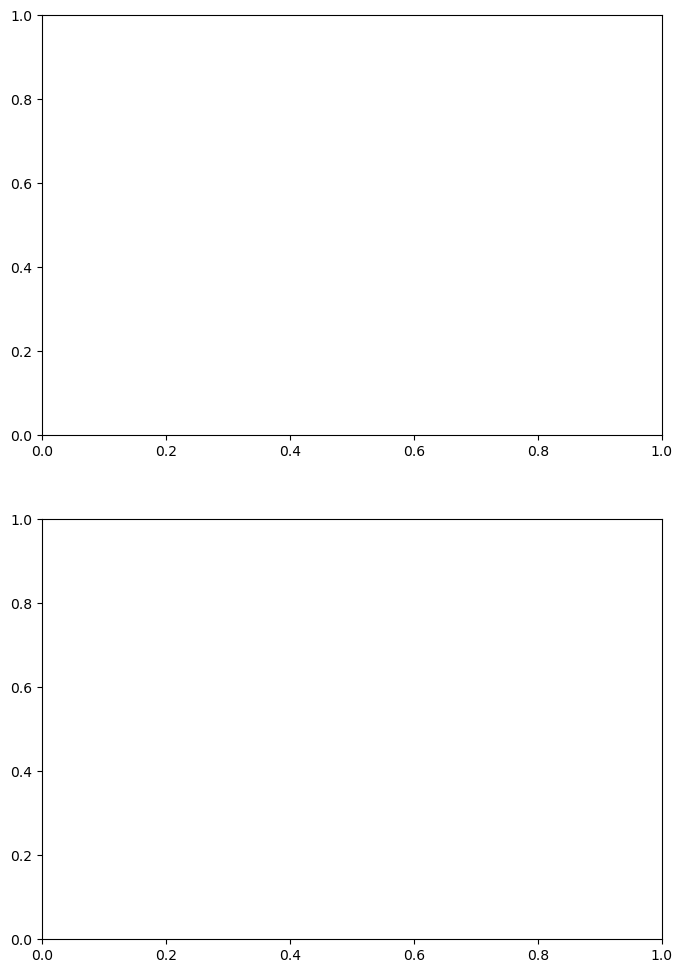

In [17]:
def region_split(label):
    return label.split("_")[-2]

class MockAtlas:
    def __init__(self, regions) -> None:
        self.macro_labels = list(map(region_split, regions))

def extract_net(mat, network):
    # Get region labels
    label_msk = np.array(atlas.macro_labels) == network
    regions = np.array(atlas.labels[label_msk])
    regions = list(np.array(regions).astype(str))

    # Extract vector and reproject to matrix
    net_masker = MatrixMasker((network,), (network,))
    if mat.ndim == 2:
        mat = mat.reshape((1, *mat.shape))
    res = net_masker.fit_transform(mat).squeeze()
    reprojected = vec_to_sym_matrix(res, diagonal=np.zeros((len(regions))))
    return reprojected, regions

def plot_network(mat, network, ax=None, **plot_kws):
    reprojected, regions = extract_net(mat, network)

    mock_atlas = MockAtlas(regions)
    
    if ax is None:
        f, ax = plt.subplots(figsize=(8, 6))
    plot_matrix(reprojected, mock_atlas, axes=ax, **plot_kws)
    ax.set_xticklabels(np.unique(mock_atlas.macro_labels), rotation=90)
    return ax, reprojected

def net_to_brain(matrix, atlas, refnet):
    reprojected, regions = extract_net(matrix, refnet)
    
    centralities = []
    for i, r in enumerate(regions):
        centralities.append(
            reprojected[i, :].sum() / 2
        )

    padded_centralities = []
    pointer = 0
    for net in atlas.macro_labels:
        if net == refnet:
            padded_centralities.append(centralities[pointer])
            pointer += 1
        else:
            padded_centralities.append(0)
    
    padded_centralities = np.array(padded_centralities)

    masker = NiftiLabelsMasker(atlas.maps)
    masker.fit()
    img = masker.inverse_transform(padded_centralities)
    return img

from matplotlib.backends.backend_pdf import PdfPages
bounds = (-0.005, 0.005)

with PdfPages("output/zooms_.pdf") as pages:
    for net in np.unique(atlas.macro_labels):
        coords = None
        for i in range(3):

            diffmap = (thresh_map[(i+1) % 3, ...] - thresh_map[i, ...])

            fig, axes = plt.subplots(2, 1, figsize=(8, 12))
            fig.suptitle(f"{cats[i+1]} - {cats[i]}")
            axes[0].set_title(net)
            axes[1].set_title("Sum of edges")
            
            plot_network(diffmap, net, cmap="seismic", bounds=bounds, ax=axes[0], cbar_kws={'label': 'Haufe pattern'})
            img = net_to_brain(diffmap, atlas, net)
            disp = plotting.plot_stat_map(img, cmap="seismic", vmin=bounds[0], vmax=bounds[1], cut_coords=coords, axes=axes[1], colorbar=False)
            coords = disp.cut_coords
            pages.savefig()
            plt.close()

### Compute ICC

In [92]:
import pingouin
from pingouin import intraclass_corr

pingouin.options['round'] = 5

data = sym_matrix_to_vec(hmat, discard_diagonal=True)

region_idx = tuple(range(data.shape[2])) * data.shape[1]
region_idx = list(map(str, region_idx))
frames = []
for i, ratings in enumerate(data):
    frame = pd.DataFrame(ratings.T, columns=cats)
    frame["model"] = f"model_{i}"
    frame = frame.melt(id_vars="model", var_name="cognitive_trajectory")
    frame["cognitive_trajectory"] = frame["cognitive_trajectory"] + region_idx
    frames.append(frame)

ModuleNotFoundError: No module named 'pingouin'

In [53]:
long_rating = pd.concat(frames)
res = intraclass_corr(long_rating, targets="cognitive_trajectory", raters="model", ratings="value")
res

(    Type              Description      ICC         F    df1     df2  pval  \
 0   ICC1   Single raters absolute  0.77721  28.90872  59699  417900   0.0   
 1   ICC2     Single random raters  0.77722  28.92558  59699  417893   0.0   
 2   ICC3      Single fixed raters  0.77732  28.92558  59699  417893   0.0   
 3  ICC1k  Average raters absolute  0.96541  28.90872  59699  417900   0.0   
 4  ICC2k    Average random raters  0.96541  28.92558  59699  417893   0.0   
 5  ICC3k     Average fixed raters  0.96543  28.92558  59699  417893   0.0   
 
           CI95%  
 0  [0.78, 0.78]  
 1  [0.78, 0.78]  
 2  [0.78, 0.78]  
 3  [0.96, 0.97]  
 4  [0.96, 0.97]  
 5  [0.97, 0.97]  ,
 0.7751400255102281,
 0.7794887967390942)

### Aggregate results by network

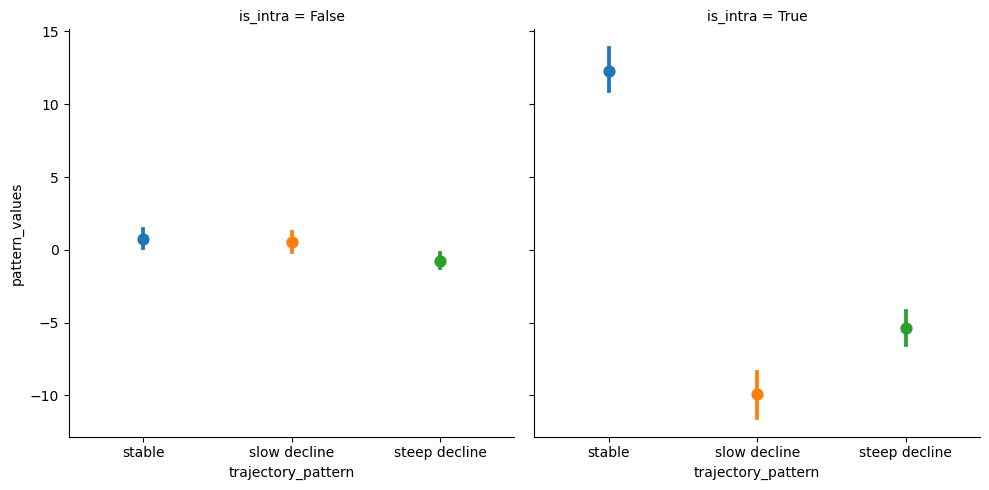

In [55]:
def all_block(block):
    return block[block != 0]

comparisons = pd.DataFrame(columns=["node_a", "node_b", "trajectory_pattern"])
for i, cat in enumerate(cats):
    netmap = thresh_map.mean(axis=0)[i, :, :]
    m = MatrixResult(netmap, atlas)
    gen = m._gen_macro_values(all_block)
    new_df = pd.DataFrame(gen).rename(columns={
        0: "node_a",
        1: "node_b",
    })
    new_df["trajectory_pattern"] = cat
    comparisons = pd.concat([comparisons, new_df])

comparisons["is_intra"] = (comparisons.node_a == comparisons.node_b)
res = comparisons.melt(
    id_vars=["node_a", "node_b", "trajectory_pattern", "is_intra"], var_name="region", value_name="pattern_values"
).dropna()

sns.catplot(res, x="trajectory_pattern", hue="trajectory_pattern", y="pattern_values", col="is_intra", kind="point", errorbar="ci")
plt.show()

In [56]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# TODO Non parametric, Dunn's test from scikit posthocs
data = res[res.is_intra == False]
model = ols(
    "pattern_values ~ C(trajectory_pattern)", data=data
).fit()

tukey = pairwise_tukeyhsd(endog=data['pattern_values'],  # Dependent variable
                          groups=data['trajectory_pattern'],  # Group variable
                          alpha=0.05)
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1        group2    meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------
slow decline        stable   0.2452 0.8658 -0.8787  1.3691  False
slow decline steep decline  -1.2702 0.0712 -2.6236  0.0832  False
      stable steep decline  -1.5153 0.0107 -2.7438 -0.2869   True
-----------------------------------------------------------------
